#### Import Modules

In [1]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier, XGBRFClassifier
from sklearn.model_selection import cross_val_score

import sys
sys.path.append("../")

from scripts.modeling_utils import run_train_pipeline, get_pipeline

from scripts.util import *
from scripts.data_cleaner import DataCleaner
from scripts.visualizer import Plotters
from sklearn.utils import shuffle

import os
import mlflow

#### Read Data

In [2]:
df  = pd.read_csv("../data/ABtwoCampaignEngView.csv")
df.head()

,Unnamed: 0,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
0,1333639,8ec30aff-2332-4a1f-9330-b93abb32bc94,control,<built-in method date of Timestamp object at 0...,15,LG,156,6,0.0,0.0
1,730667,4e1bcb56-357c-4186-9d39-3be82e3519f1,control,<built-in method date of Timestamp object at 0...,7,Samsung,162,6,0.0,0.0
2,2069787,dd6ec327-fcfd-4a80-89c0-dccd3dd80f09,control,<built-in method date of Timestamp object at 0...,14,Apple,178,15,0.0,0.0
3,1692366,b5222d0f-39e3-4c02-a12f-1ef09d4f861f,control,<built-in method date of Timestamp object at 0...,22,Apple,167,15,0.0,0.0
4,1384123,9428377d-1504-4407-87c2-ce518f67eb87,control,<built-in method date of Timestamp object at 0...,21,Samsung,155,15,0.0,0.0


In [3]:
df.shape

(912712, 10)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 912712 entries, 0 to 912711
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Unnamed: 0   912712 non-null  int64  
 1   auction_id   912712 non-null  object 
 2   experiment   912712 non-null  object 
 3   date         912712 non-null  object 
 4   hour         912712 non-null  int64  
 5   device_make  912712 non-null  object 
 6   platform_os  912712 non-null  int64  
 7   browser      912712 non-null  int64  
 8   yes          912712 non-null  float64
 9   no           912712 non-null  float64
dtypes: float64(2), int64(4), object(4)
memory usage: 69.6+ MB


#### Clean Data 

In [5]:
#Check if there are any missing values
totalCells = np.product(df.shape)
missingCount = df.isnull().sum()
totalMissing = missingCount.sum()
print("The dataset contains", round(
            ((totalMissing/totalCells) * 100), 2), "%", "missing values.")

#We can see that there are no missing values in the dataset

The dataset contains 0.0 % missing values.


In [6]:
display(df[df.duplicated('auction_id', False)].head())
print("Duplicated rows:", df[df.duplicated('auction_id', False)].shape[0])

,Unnamed: 0,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
153,611695,415c4ac6-cc80-4f84-856c-9e821ba37fa7,control,<built-in method date of Timestamp object at 0...,19,Apple,101,7,0.0,0.0
180,105739,0b4b114a-7be3-435e-beb5-76cbd29ae329,control,<built-in method date of Timestamp object at 0...,8,Apple,101,15,0.0,1.0
336,1752177,bb84fd6a-7353-4157-9f84-e30159e38b8e,control,<built-in method date of Timestamp object at 0...,6,Apple,101,15,0.0,0.0
509,460884,3144fd93-dc96-424c-8ba8-6f24078d3c09,control,<built-in method date of Timestamp object at 0...,22,Apple,171,7,0.0,0.0
566,303927,20715f98-69b8-41aa-ae78-5ab1b65682a2,control,<built-in method date of Timestamp object at 0...,20,Apple,101,7,0.0,0.0


Duplicated rows: 39358


We can see that there are about 39358 duplicated values/rows and We can see that the column date only holds the methon signature as a string(in other words its just str(function))
1. We will drop the column `no`, we can just use column 'yes' as a binary classifier for a response
2. We will drop the column `data`, since it holds insignificant information
3. We will drop the column `auction_id` since it is irrelevant for this task
4. We will drop the column `Unamed: 0` since we have index, having two index is not important 

#### Remove unwanted columns

In [7]:
cleaner = DataCleaner()
df_cleaned = cleaner.drop_duplicates(df)
df_cleaned = cleaner.drop_unresponsive(df_cleaned)
df_cleaned = cleaner.drop_columns(df=df_cleaned,
                columns=['Unnamed: 0', 'auction_id', 'date', 'no'])
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96617 entries, 80 to 912706
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   experiment   96617 non-null  object 
 1   hour         96617 non-null  int64  
 2   device_make  96617 non-null  object 
 3   platform_os  96617 non-null  int64  
 4   browser      96617 non-null  int64  
 5   yes          96617 non-null  float64
dtypes: float64(1), int64(3), object(2)
memory usage: 5.2+ MB


#### Save Cleaned Data

In [12]:
df.to_csv("../data/CleanedABtwoCampaignEngView.csv")

### EDA

#### Univariate analysis on numerical columns

In [8]:
get_univariate_analysis(df_cleaned)

,count,mean,std,min,25%,50%,75%,max,mode,CoV,skew,kurtosis,iqr,missing_counts
hour,96617.0,10.063571,7.387838,0.0,3.0,10.0,17.0,23.0,2.0,0.734117,0.178519,-1.415354,14.0,0
platform_os,96617.0,117.050964,27.770550,101.0,101.0,101.0,145.0,180.0,101.0,0.237252,1.219523,-0.359402,44.0,0
browser,96617.0,7.930250,3.549317,1.0,6.0,6.0,7.0,15.0,6.0,0.447567,1.467704,0.205009,1.0,0
yes,96617.0,0.875560,0.330084,0.0,1.0,1.0,1.0,1.0,1.0,0.376998,-2.275588,3.178367,0.0,0


`platform_os` and `browser` are pre encoded

#### Visualizations

##### Top 10 Browsers

6     64421
15    19293
7     12770
5        79
12       34
1        11
8         9
Name: browser, dtype: int64

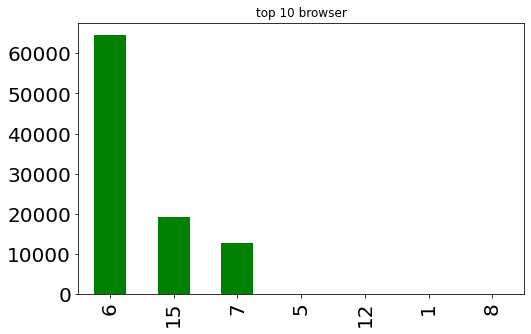

In [9]:
my_plt = Plotters(w=8, h=5)
# my_plt.plot_hist(df_cleaned.groupby('browser').value_counts(), 'browser', color="blue")
my_plt.plot_top_n_counts(df_cleaned, 'browser', top_n=10, title="top 10 browser")

##### Top 10 Platform OS

101    71855
162     8605
156     4232
178     3508
155     3180
179     1135
174      783
175      646
173      374
171      374
Name: platform_os, dtype: int64

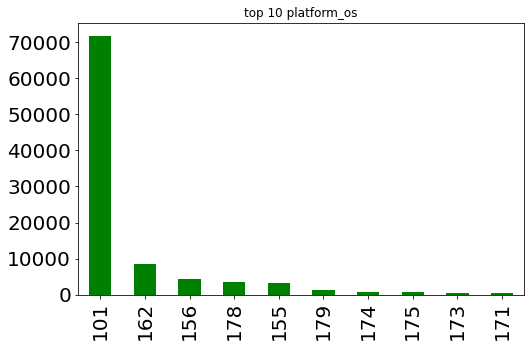

In [10]:
my_plt.plot_top_n_counts(df_cleaned, 'platform_os', top_n=10, title="top 10 platform_os")

##### Top 10 Device Make

Samsung     46525
Apple       23065
Google      20908
Motorola     2285
LG           1619
OnePlus       684
Amazon        287
TCL           274
HTC            90
Xiaomi         69
Name: device_make, dtype: int64

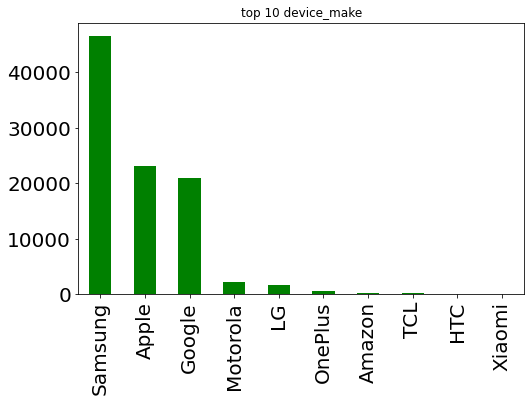

In [11]:
my_plt.plot_top_n_counts(df_cleaned, 'device_make', top_n=10, title="top 10 device_make")

Check proportions of `experiment` vs `control` groups

exposed    78973
control    17644
Name: experiment, dtype: int64


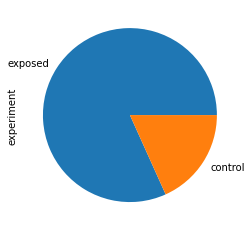

In [15]:
df_cleaned.experiment.value_counts().plot(kind='pie');
print(df_cleaned.experiment.value_counts())
#We can see that exposed samples are alost 5 times more than control samples

##### Lets try to model before resampling the data.

##### We already have a pipeline that uses sklearn.pipelines, we will use that to train our model

In [21]:
try:
    mlflow.end_run()
except:
    pass

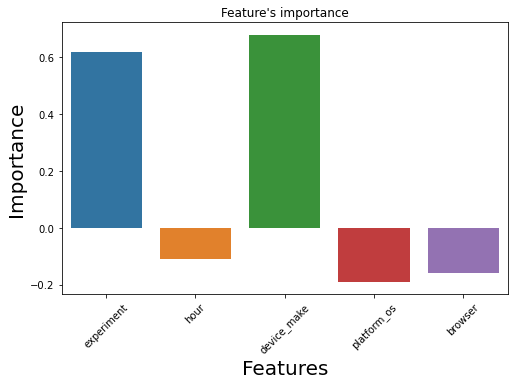

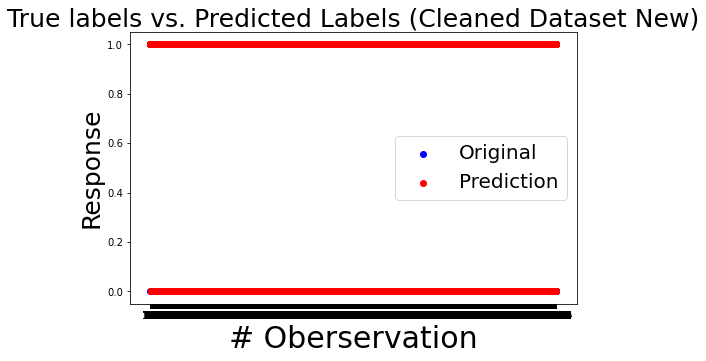

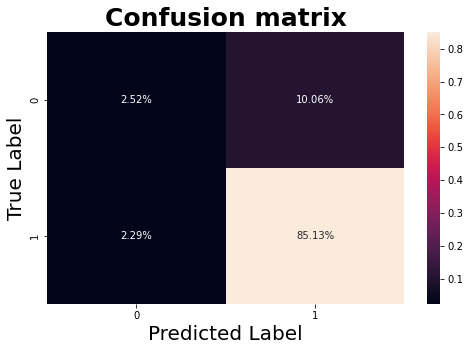

{'accuracy': 0.88, 'precision': 0.89, 'recall': 0.97, 'entropy': 0.29, 'true_pos': 730, 'true_neg': 24676, 'false_pos': 2916, 'false_neg': 664}
{'experiment': 0.62, 'hour': -0.11, 'device_make': 0.68, 'platform_os': -0.19, 'browser': -0.16}


2022/09/02 18:08:15 INFO mlflow.tracking.fluent: Experiment with name 'Cleaned Dataset New' does not exist. Creating a new experiment.


Run params saved
Run metrics saved
logging figures
figures saved with mlflow
figures saved
Saving artifacts
saving dict


Successfully registered model 'Cleaned Dataset New_Logistic Regression on unbalanced data_Fri-Sep--2-18:10:02-2022'.
2022/09/02 18:10:12 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: Cleaned Dataset New_Logistic Regression on unbalanced data_Fri-Sep--2-18:10:02-2022, version 1
Created version '1' of model 'Cleaned Dataset New_Logistic Regression on unbalanced data_Fri-Sep--2-18:10:02-2022'.


Run - Logistic Regression on unbalanced data is logged to Experiment - Cleaned Dataset New


In [22]:
X = df_cleaned.drop(columns=['yes'])
y = df_cleaned['yes'].values

model = LogisticRegression()
run_train_pipeline(model, X, y, 
                experiment_name='Cleaned Dataset New',
                run_name='Logistic Regression on unbalanced data')

mlflow.end_run()

`We can see that the model performs good but let's check after balancing the data`

In [24]:
import warnings
warnings.filterwarnings('ignore')
exposed = df_cleaned[df_cleaned['experiment']=='exposed'].reset_index(drop=True)
exposed = shuffle(exposed).reset_index(drop=True)
control = df_cleaned[df_cleaned['experiment']=='control'].reset_index(drop=True)
balanced_by_experiment = control.append(exposed.loc[:len(control), :])

balanced_by_experiment = shuffle(balanced_by_experiment).reset_index(drop=True)

In [25]:
try:
    mlflow.end_run()
except:
    pass

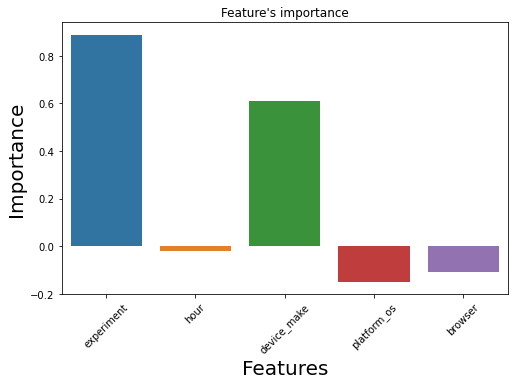

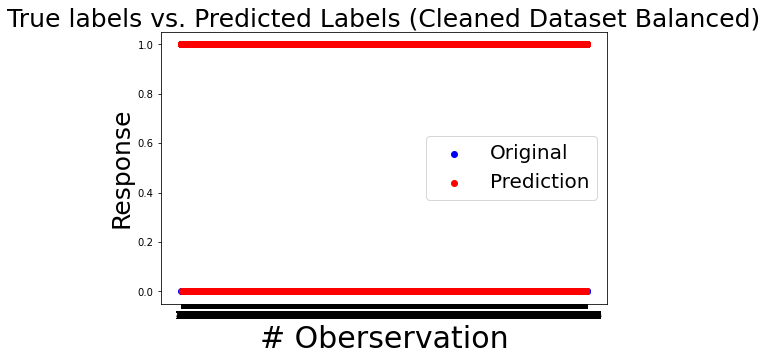

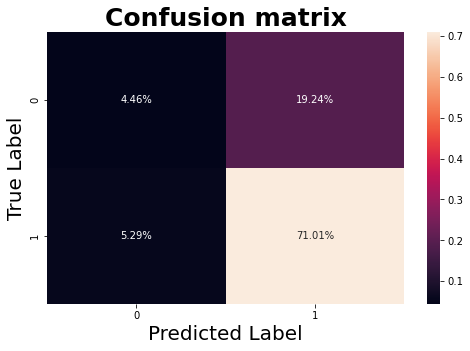

{'accuracy': 0.75, 'precision': 0.79, 'recall': 0.93, 'entropy': 0.44, 'true_pos': 472, 'true_neg': 7518, 'false_pos': 2037, 'false_neg': 560}
{'experiment': 0.89, 'hour': -0.02, 'device_make': 0.61, 'platform_os': -0.15, 'browser': -0.11}


2022/09/02 18:16:14 INFO mlflow.tracking.fluent: Experiment with name 'Cleaned Dataset Balanced' does not exist. Creating a new experiment.


Run params saved
Run metrics saved
logging figures
figures saved with mlflow
figures saved
Saving artifacts
saving dict


Successfully registered model 'Cleaned Dataset Balanced_logistic regression_Fri-Sep--2-18:16:58-2022'.
2022/09/02 18:17:07 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: Cleaned Dataset Balanced_logistic regression_Fri-Sep--2-18:16:58-2022, version 1
Created version '1' of model 'Cleaned Dataset Balanced_logistic regression_Fri-Sep--2-18:16:58-2022'.


Run - logistic regression is logged to Experiment - Cleaned Dataset Balanced


In [26]:
X = balanced_by_experiment.drop(columns=['yes'])
y = balanced_by_experiment['yes'].values

model = LogisticRegression()
run_train_pipeline(model, X, y, 
                experiment_name='Cleaned Dataset Balanced',
                run_name='logistic regression')

mlflow.end_run()

`We will check if yes and no are balanced which means in our case 1's and 0's in the column 'yes'`

In [27]:
balanced_by_experiment.yes.value_counts()

1.0    26972
0.0     8317
Name: yes, dtype: int64

`We can see that we have way more 1's in our column 'yes' this explains why we have a good result in the 4th quadrant in the confusion matrix`
`Let's cross check using XGBoost Classifier based on RandomForest`

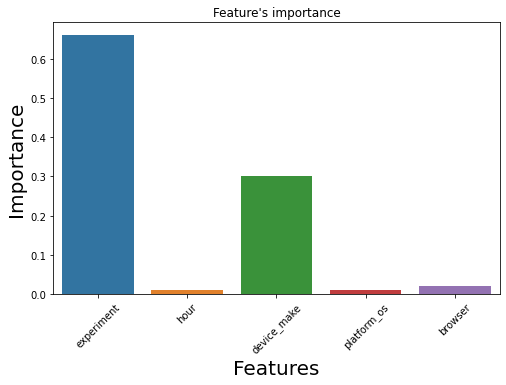

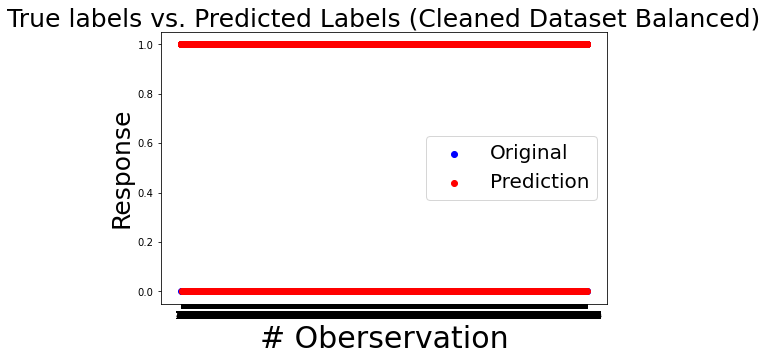

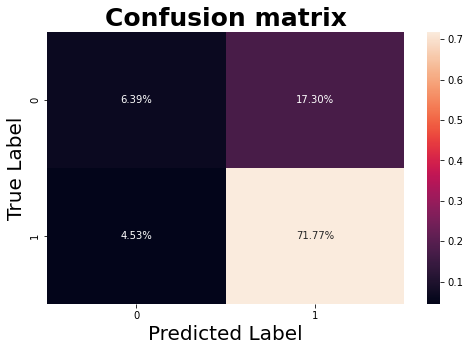

{'accuracy': 0.78, 'precision': 0.81, 'recall': 0.94, 'entropy': 0.45, 'true_pos': 677, 'true_neg': 7598, 'false_pos': 1832, 'false_neg': 480}
{'experiment': 0.66, 'hour': 0.01, 'device_make': 0.3, 'platform_os': 0.01, 'browser': 0.02}
Run params saved
Run metrics saved
logging figures
figures saved with mlflow
figures saved
Saving artifacts
saving dict


Successfully registered model 'Cleaned Dataset Balanced_XGBRFClassifier_Fri-Sep--2-18:24:30-2022'.
2022/09/02 18:24:36 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: Cleaned Dataset Balanced_XGBRFClassifier_Fri-Sep--2-18:24:30-2022, version 1
Created version '1' of model 'Cleaned Dataset Balanced_XGBRFClassifier_Fri-Sep--2-18:24:30-2022'.


Run - XGBRFClassifier is logged to Experiment - Cleaned Dataset Balanced


In [28]:
mlflow.end_run()
model = XGBRFClassifier()
run_train_pipeline(model, X, y, 
                experiment_name='Cleaned Dataset Balanced',
                run_name='XGBRFClassifier')

mlflow.end_run()

`We can see that the column 'experiment' has a high posetive correlation with the target value.`

`We will try to balance the values now`

In [29]:
aware = df_cleaned.query("yes==1").reset_index(drop=True)
aware = shuffle(aware).reset_index(drop=True)
not_aware = df_cleaned.query("yes==0").reset_index(drop=True)
aware = aware.loc[:not_aware.shape[0], :].copy()
balanced_by_response = pd.concat([aware, not_aware])
balanced_by_response = shuffle(balanced_by_response).reset_index(drop=True)
display(balanced_by_response.info())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24047 entries, 0 to 24046
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   experiment   24047 non-null  object 
 1   hour         24047 non-null  int64  
 2   device_make  24047 non-null  object 
 3   platform_os  24047 non-null  int64  
 4   browser      24047 non-null  int64  
 5   yes          24047 non-null  float64
dtypes: float64(1), int64(3), object(2)
memory usage: 1.1+ MB


None

##### Save the balanced data

In [30]:
balanced_by_response.to_csv('../data/CleanedBalancedABtwoCampaignEngView.csv')

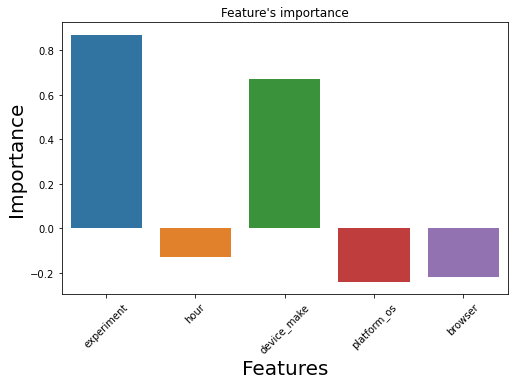

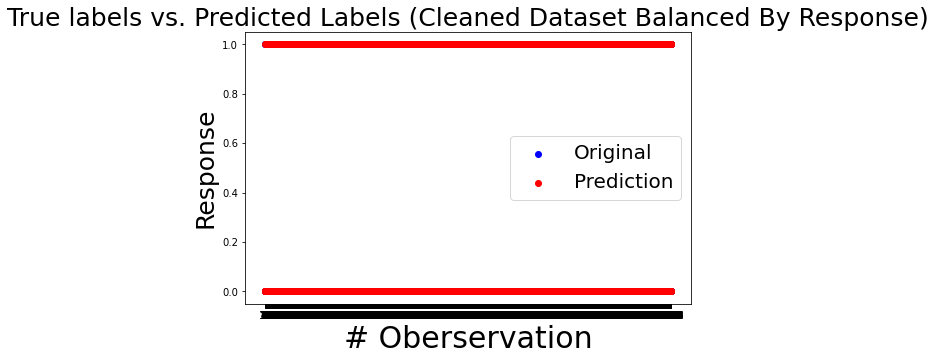

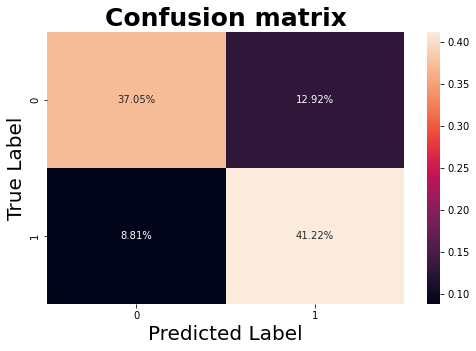

{'accuracy': 0.78, 'precision': 0.76, 'recall': 0.82, 'entropy': 0.51, 'true_pos': 2673, 'true_neg': 2974, 'false_pos': 932, 'false_neg': 636}
{'experiment': 0.87, 'hour': -0.13, 'device_make': 0.67, 'platform_os': -0.24, 'browser': -0.22}


2022/09/02 18:36:58 INFO mlflow.tracking.fluent: Experiment with name 'Cleaned Dataset Balanced By Response' does not exist. Creating a new experiment.


Run params saved
Run metrics saved
logging figures
figures saved with mlflow
figures saved
Saving artifacts
saving dict


Successfully registered model 'Cleaned Dataset Balanced By Response_logistic regression_Fri-Sep--2-18:37:33-2022'.
2022/09/02 18:37:38 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: Cleaned Dataset Balanced By Response_logistic regression_Fri-Sep--2-18:37:33-2022, version 1
Created version '1' of model 'Cleaned Dataset Balanced By Response_logistic regression_Fri-Sep--2-18:37:33-2022'.


Run - logistic regression is logged to Experiment - Cleaned Dataset Balanced By Response


In [31]:
X = balanced_by_response.drop(columns=['yes'])
y = balanced_by_response['yes'].values

model = LogisticRegression()
run_train_pipeline(model, X, y, 
                experiment_name='Cleaned Dataset Balanced By Response',
                run_name='logistic regression')

mlflow.end_run()

`We can say that the column 'experiment' has major contribution to our model. And concluding that customers brand awareness has changed based on the experiment group they were in`.